# q1:Hough Transform

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

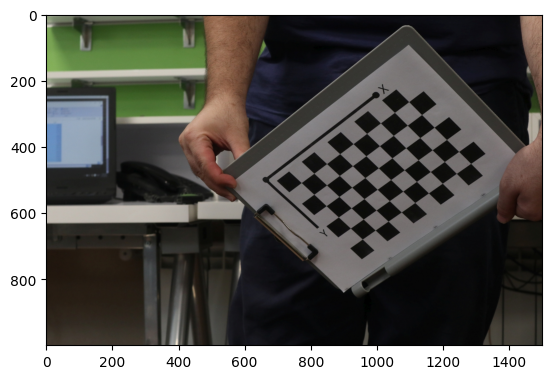

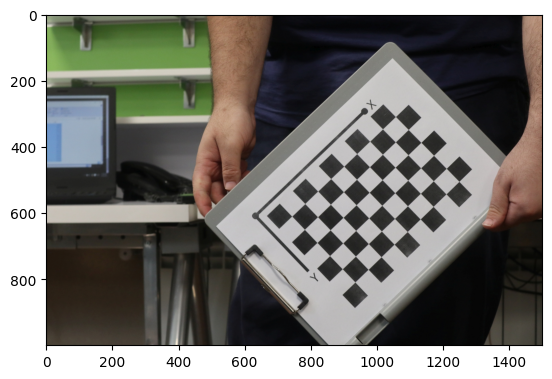

In [3]:
img1 = cv2.cvtColor(cv2.imread("Checker1.jpg"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread("Checker2.jpg"), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.figure()
plt.imshow(img2)


Performing edge detection :

In [11]:
#edge detecting with canny
def edge_detection(image,t1,t2): 
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image_blurred = cv2.GaussianBlur(image_gray, (5, 5), 0)
    image_output = cv2.Canny(image_blurred,t1,t2)
    return image_output

True

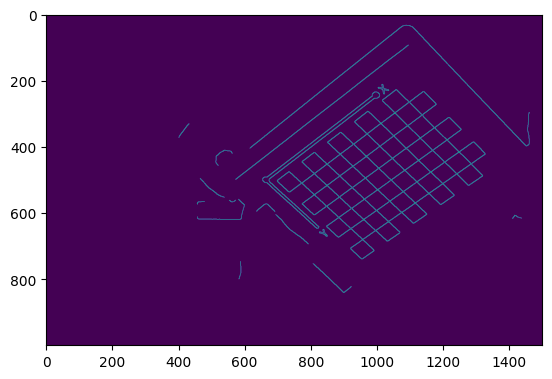

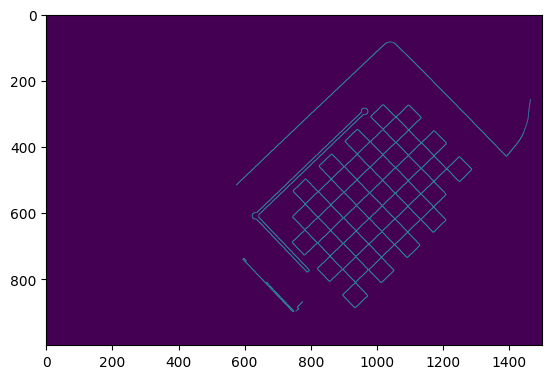

In [14]:
#plot and save edges
img1_edges = edge_detection(img1,180,300)
img2_edges = edge_detection(img2,200,500)
plt.imshow(img1_edges)
plt.figure()
plt.imshow(img2_edges)
# save
cv2.imwrite('result01.jpg', img1_edges)
cv2.imwrite('result02.jpg', img2_edges)

In [32]:
def hough_tranaform(img, q_level):
    img_width, img_length = img.shape
    r = int(np.ceil((img_width ** 2 + img_length ** 2) ** (1/2)))
    accumulator_matrix = np.zeros(shape=(r, q_level, 7))
    for i in range(img_width):
        for j in range(img_length):
            if img[i, j] > 10: 
                for theta in range(q_level):                     
                    angle = theta/180 * np.pi                     
                    rho = int(i * np.cos(angle) - j * np.sin(angle))
                    accumulator_matrix[rho, theta, 0] += 1
                    if (accumulator_matrix[rho, theta, 1] == 0) & (accumulator_matrix[rho, theta, 2] == 0): 
                        accumulator_matrix[rho, theta, 1] = i
                        accumulator_matrix[rho, theta, 2] = j
                    if (accumulator_matrix[rho, theta, 3] == 0) & (accumulator_matrix[rho, theta, 4] == 0):
                        accumulator_matrix[rho, theta, 3] = i
                        accumulator_matrix[rho, theta, 4] = j
                    if i < accumulator_matrix[rho, theta, 1]:
                        accumulator_matrix[rho, theta, 1] = i
                        accumulator_matrix[rho, theta, 2] = j
                    if i > accumulator_matrix[rho, theta, 3]:
                        accumulator_matrix[rho, theta, 3] = i
                        accumulator_matrix[rho, theta, 4] = j
                    if (i == accumulator_matrix[rho, theta, 1]) & (j < accumulator_matrix[rho, theta, 2]):
                        accumulator_matrix[rho, theta, 1] = i
                        accumulator_matrix[rho, theta, 2] = j
                    if (i == accumulator_matrix[rho, theta, 3]) & (j > accumulator_matrix[rho, theta, 4]):
                        accumulator_matrix[rho, theta, 3] = i
                        accumulator_matrix[rho, theta, 4] = j      
                    accumulator_matrix[rho, theta, 5] += i
                    accumulator_matrix[rho, theta, 6] += j      
    return accumulator_matrix

def edges(img_input, accumulator_matrix, threshold):
    rho, theta = np.where(accumulator_matrix[:, :, 0] > threshold)
    img = img_input.copy()
    for i in range(len(rho)):
        p = rho[i]
        angle = theta[i]
        x_start = int(accumulator_matrix[p, angle, 1])
        y_start = int(accumulator_matrix[p, angle, 2])
        x_end = int(accumulator_matrix[p, angle, 3])
        y_end = int(accumulator_matrix[p, angle, 4])    
        cv2.line(img, (y_start, x_start), (y_end, x_end), (255,0, 0), 3)
    return img

def chess_edges(img_input, accumulator_matrix, threshold1=80, threshold2=80, th_error=5, dis_error=5, chessboard_len1=5, chessboard_len2=5, node_flag=False):
    rho, theta = np.where(accumulator_matrix[:, :, 0] > np.min((threshold1, threshold2)))
    v = accumulator_matrix[rho, theta, 0]
    result = np.concatenate((rho.reshape(-1, 1), theta.reshape(-1, 1), v.reshape(-1, 1)), axis=1)
    result = result[result[:, 2].argsort()[::-1]]
    theta_list = list(result[:, 1])
    thr = np.min((10, len(theta_list)))
    theta_list = theta_list[:thr]
    theta_list = sorted(theta_list, key=lambda x: theta_list.count(x), reverse=True)
    list1_th = theta_list[0]
    for i in range(len(theta_list)):
        th = theta_list[i] 
        if (th > list1_th + 10) | (th < list1_th - 10):
            list2_th = th
            break
    list1 = []
    list2 = []
    for i in range(np.min((result.shape[0], 500))):
        p = result[i, 0]
        th = result[i, 1] 
        v = result[i, 2]
        if (th > list1_th - th_error) & (th < list1_th + th_error):
            help_arr = np.array(list1)
            my_flag = np.any((help_arr > p - 5) & (help_arr < p + 5))
            if not my_flag: 
                list1.append(p)
        elif (th > list2_th - th_error) & (th < list2_th + th_error):
            help_arr = np.array(list2)
            my_flag = np.any((help_arr > p - 5) & (help_arr < p + 5))
            if not my_flag: 
                list2.append(p)
    line_th1 = np.min((7, len(list1)))
    line_th2 = np.min((7, len(list2)))
    list1 = list1[:line_th1]
    list2 = list2[:line_th2]
    list1 = sorted(list1, reverse=True)
    list2 = sorted(list2, reverse=True)
    list1_d = []
    list2_d = []
    for i in range(line_th1-1):
        list1_d.append(list1[i] - list1[i+1])   
    for i in range(line_th2-1):
        list2_d.append(list2[i] - list2[i+1])
    list1_d = sorted(list1_d, key=lambda x: list1_d.count(x), reverse=True)
    list2_d = sorted(list2_d, key=lambda x: list2_d.count(x), reverse=True)
    list1_dis = list1_d[0]
    list2_dis = list2_d[0]
    for i in range(line_th1-1):
        dis = list1[i] - list1[i+1]
        if (dis > list1_dis - dis_error) & (dis < list1_dis + dis_error):
            list1_vp = list1[i]
    for i in range(line_th2-1):
        dis = list2[i] - list2[i+1]
        if (dis > list2_dis - dis_error) & (dis < list2_dis + dis_error):
            list2_vp = list2[i] 
    list1_line_counter = np.ones(shape = (2 * chessboard_len1 + 1, 1))
    list2_line_counter = np.ones(shape = (2 * chessboard_len2 + 1, 1))
    img = img_input.copy()
    node_lists1 = []
    node_lists2 = []
    for i in range(np.min((len(rho)))):
        p = int(result[i, 0])
        angle = int(result[i, 1])
        vo = result[i, 2] 
        case1_angle = (angle > list1_th - th_error) & (angle < list1_th + th_error)
        case1_p = np.abs(p - list1_vp) % list1_dis 
        case1_p = (case1_p <= dis_error) | (case1_p >= list1_dis - dis_error)
        case1_count = np.max((np.abs(p + dis_error - list1_vp), np.abs(p - dis_error - list1_vp)))
        case1_count = np.floor(case1_count / list1_dis) * np.sign(p - list1_vp)
        counter1 = case1_count.copy()
        if np.abs(case1_count) < chessboard_len1: 
            case1_count = list1_line_counter[int(case1_count) + chessboard_len1, 0]
        else:
            case1_count = 0
        case1_count = case1_count > 0 
        case1_vo = vo > threshold1
        case2_angle = (angle > list2_th - th_error) & (angle < list2_th + th_error)
        case2_p = np.abs(p - list2_vp) % list2_dis 
        case2_p = (case2_p <= dis_error) | (case2_p >= list2_dis - dis_error)    
        case2_count = np.max((np.abs(p + dis_error - list2_vp), np.abs(p - dis_error - list2_vp)))
        case2_count = np.floor(case2_count / list2_dis) * np.sign(p - list2_vp)
        counter2 = case2_count.copy()
        if np.abs(case2_count) < chessboard_len2: 
            case2_count = list2_line_counter[int(case2_count) + chessboard_len2, 0]
        else:
            case2_count = 0
        case2_count = case2_count > 0 
        case2_vo = vo > threshold2
        if (case1_angle & case1_p & case1_count & case1_vo):
            theta = angle * np.pi / 180 
            line_len = int(accumulator_matrix[p, angle, 0])
            x_center = int(accumulator_matrix[p, angle, 5] / line_len)
            y_center = int(accumulator_matrix[p, angle, 6] / line_len)
            line_len = 2000
            x_start = int(x_center - line_len / 2 * np.sin(theta))
            y_start = int(y_center - line_len / 2 * np.cos(theta))
            x_end = int(x_center + line_len / 2 * np.sin(theta))
            y_end = int(y_center + line_len / 2 * np.cos(theta)) 
            x_start = int(accumulator_matrix[p, angle, 1])
            y_start = int(accumulator_matrix[p, angle, 2])
            x_end = int(accumulator_matrix[p, angle, 3])
            y_end = int(accumulator_matrix[p, angle, 4])
            list1_line_counter[int(counter1) + chessboard_len1, 0] -= 1
            cv2.line(img, (y_start, x_start), (y_end, x_end), (255,0, 0), 3)
            node_lists1.append((y_start, x_start, y_end, x_end))
        if (case2_angle & case2_p & case2_count & case2_vo):
            theta = angle * np.pi / 180 
            line_len = int(accumulator_matrix[p, angle, 0])
            x_center = int(accumulator_matrix[p, angle, 5] / line_len)
            y_center = int(accumulator_matrix[p, angle, 6] / line_len)
            line_len = 2500
            x_start = int(x_center - line_len / 2 * np.sin(theta))
            y_start = int(y_center - line_len / 2 * np.cos(theta))
            x_end = int(x_center + line_len / 2 * np.sin(theta))
            y_end = int(y_center + line_len / 2 * np.cos(theta)) 
            list2_line_counter[int(counter2) + chessboard_len2, 0] -= 1 
            x_start = int(accumulator_matrix[p, angle, 1])
            y_start = int(accumulator_matrix[p, angle, 2])
            x_end = int(accumulator_matrix[p, angle, 3])
            y_end = int(accumulator_matrix[p, angle, 4])
            cv2.line(img, (y_start, x_start), (y_end, x_end), (255,0, 0), 3)
            node_lists2.append((y_start, x_start, y_end, x_end))
        if node_flag:
            for node1 in node_lists1:
                for node2 in node_lists2:
                    a1 = (node1[0] - node1[2]) / (node1[1] - node1[3])
                    a2 = (node2[0] - node2[2]) / (node2[1] - node2[3])
                    b1 = node1[0] - a1 * node1[1]
                    b2 = node2[0] - a2 * node2[1]
                    x_common = int((b2 - b1) / (a1 - a2))
                    y_common = int(a1 * x_common + b1)
                    cv2.circle(img, (y_common, x_common), 5, (255,255,255), -1)
    return img

In [29]:
#hough transform
mat1 = hough_tranaform(img1_edges, 180)
mat2 = hough_tranaform(img2_edges, 180)
#save
cv2.imwrite('result03_Hough_space.jpg',mat1[:, :, 0])
cv2.imwrite('result04_Hough_space.jpg',mat2[:, :, 0])

True

True

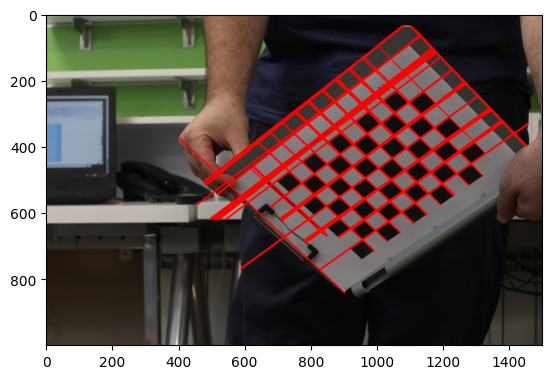

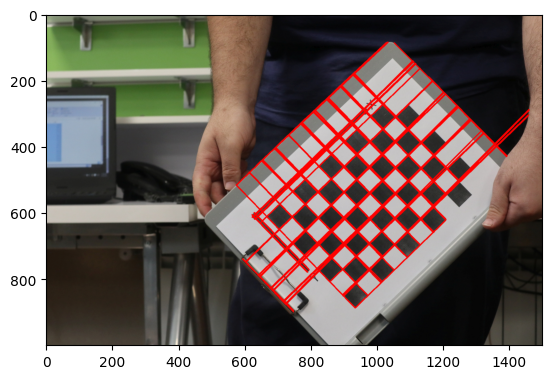

In [33]:
out1 = edges(img1,mat1, 128)
out2 = edges(img2,mat2, 128)
#plot results
plt.imshow(out1)
plt.figure()
plt.imshow(out2)
# save
cv2.imwrite('result05_Lines.jpg',cv2.cvtColor(out1,cv2.COLOR_RGB2BGR))
cv2.imwrite('result06_Lines.jpg',cv2.cvtColor(out2,cv2.COLOR_RGB2BGR))

True

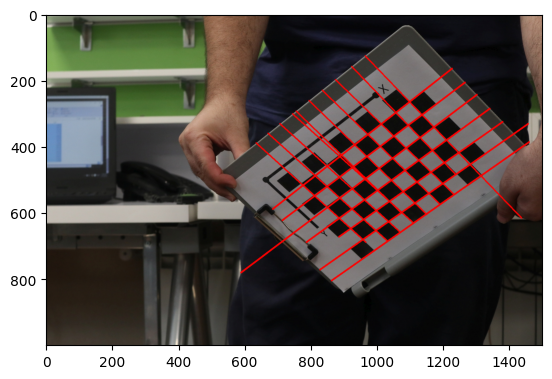

In [34]:
out1 = chess_edges(img1,mat1,80,80,5,6,4,7)
plt.imshow(out1)
# save
cv2.imwrite('result07_chess.jpg',cv2.cvtColor(out1, cv2.COLOR_RGB2BGR))

True

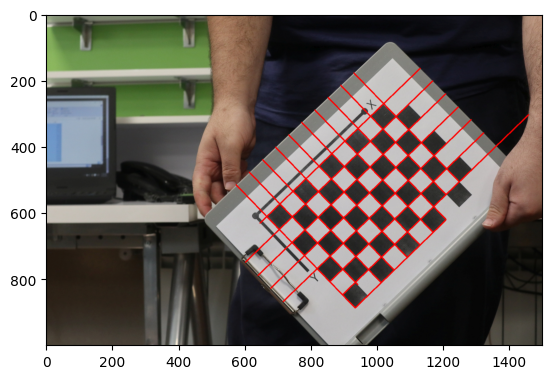

In [35]:
out2 = chess_edges(img2, mat2, 50, 50, 2, 2, 8, 8)
plt.imshow(out2)
# save
cv2.imwrite('result08_chess.jpg', cv2.cvtColor(out2, cv2.COLOR_RGB2BGR))

True

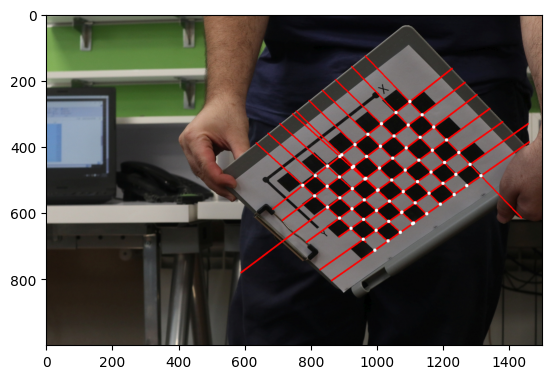

In [36]:
out1 = chess_edges(img1,mat1,80,80,5,6,4,7,True)
plt.imshow(out1)
# save
cv2.imwrite('result09_corners.jpg',cv2.cvtColor(out1, cv2.COLOR_RGB2BGR))

True

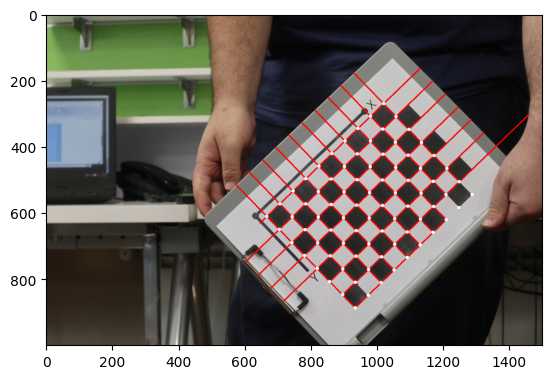

In [38]:
out2 = chess_edges(img2, mat2, 50, 50, 2, 2, 8, 8,True)
plt.imshow(out2)
# save
cv2.imwrite('result10_corners.jpg', cv2.cvtColor(out2, cv2.COLOR_RGB2BGR))